In [1]:
import Pkg
pkgs = [
    "Eisenia",
    "Random",
    "Revise",
    "BioSequences",
    "Test",
    "LightGraphs",
    "Primes",
    "Statistics",
    "Plots",
    "uCSV",
    "DataFrames",
    "HTTP",
    "CodecZlib",
    "FASTX"
]

for pkg in pkgs
    try
        Pkg.add(pkg)
    catch
#         # tried to install an unregistered local package
    end
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
┌ Info: Precompiling Eisenia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1278
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Res

In [2]:
TASK = "graph-decomposition-of-related-genomes"
DATE = "2021-02-14"
DIR = "$(homedir())/$(DATE)-$(TASK)"
if !isdir(DIR)
    mkdir(DIR)
end
cd(DIR)

In [7]:
function get_genome_from_ftp_directory(ftp_path)
    fasta_url = "$(ftp_path)/$(basename(ftp_path))_genomic.fna.gz"
    fasta_buffer = CodecZlib.GzipDecompressorStream(IOBuffer(HTTP.get(fasta_url).body))
    return collect(FASTX.FASTA.Reader(fasta_buffer))
end

get_genome_from_ftp_directory (generic function with 1 method)

In [3]:
db = "genbank"
assembly_summary_url = "https://ftp.ncbi.nlm.nih.gov/genomes/$(db)/assembly_summary_$(db).txt"
assembly_summary_response = HTTP.get(assembly_summary_url)
assembly_summary_response_buffer = IOBuffer(assembly_summary_response.body)
assembly_summary_table = DataFrames.DataFrame(uCSV.read(assembly_summary_response_buffer, delim='\t', header=2, skipmalformed=true)...)

,# assembly_accession,bioproject,biosample,wgs_master,refseq_category
,String,String,String,String,String
1,GCA_000001215.4,PRJNA13812,SAMN02803731,,reference genome
2,GCA_000001405.28,PRJNA31257,,,reference genome
3,GCA_000001515.5,PRJNA13184,SAMN02981217,AACZ00000000.4,na
4,GCA_000001545.3,PRJNA20869,SAMN02981238,ABGA00000000.1,na
5,GCA_000001635.9,PRJNA20689,,,reference genome
6,GCA_000001735.2,PRJNA10719,SAMN03081427,,reference genome
7,GCA_000001765.3,PRJNA10626,SAMN00779672,AADE00000000.2,na
8,GCA_000001895.4,PRJNA10629,SAMN02808228,AABR00000000.7,na
9,GCA_000001905.1,PRJNA12569,SAMN02953622,AAGU00000000.3,representative genome


In [4]:
genome_size_table_url = "ftp://ftp.ncbi.nlm.nih.gov/genomes/ASSEMBLY_REPORTS/species_genome_size.txt.gz"
genome_size_table_response = HTTP.get(genome_size_table_url)
genome_size_table_buffer = CodecZlib.GzipDecompressorStream(IOBuffer(genome_size_table_response.body))
genome_size_table = DataFrames.DataFrame(uCSV.read(genome_size_table_buffer, header=1, delim='\t')...)

,#species_taxid,min_ungapped_length,max_ungapped_length,expected_ungapped_length
,Int64,Int64,Int64,Int64
1,9,318000,956000,636876
2,24,2942000,6133000,4537729
3,34,7405000,11109000,9257167
4,56,5994000,15000000,11989871
5,69,4912000,7369000,6140343
6,114,7212000,10820000,9015893
7,122,6222000,9334000,7777997
8,124,5461000,9315000,7387897
9,139,813000,1786000,1299537


In [5]:
joint_table = DataFrames.innerjoin(assembly_summary_table, genome_size_table, on=["species_taxid" => "#species_taxid"])
sort!(joint_table, "expected_ungapped_length")

,# assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid
,String,String,String,String,String,Int64
1,GCA_002829805.1,,,,na,230604
2,GCA_003972145.1,,,,na,230604
3,GCA_003972165.1,,,,na,230604
4,GCA_003972185.1,,,,na,230604
5,GCA_003972205.1,,,,na,230604
6,GCA_003972225.1,,,,na,230604
7,GCA_003972245.1,,,,na,230604
8,GCA_003972265.1,,,,na,230604
9,GCA_000851485.1,,,,reference genome,154834


In [6]:
show(joint_table, allcols=true)

754335×26 DataFrame
│ Row    │ # assembly_accession │ bioproject │ biosample    │
│        │ String               │ String     │ String       │
├────────┼──────────────────────┼────────────┼──────────────┤
│ 1      │ GCA_002829805.1      │            │              │
│ 2      │ GCA_003972145.1      │            │              │
│ 3      │ GCA_003972165.1      │            │              │
│ 4      │ GCA_003972185.1      │            │              │
│ 5      │ GCA_003972205.1      │            │              │
│ 6      │ GCA_003972225.1      │            │              │
│ 7      │ GCA_003972245.1      │            │              │
│ 8      │ GCA_003972265.1      │            │              │
│ 9      │ GCA_000851485.1      │            │              │
│ 10     │ GCA_000856565.1      │            │              │
⋮
│ 754325 │ GCA_902810675.1      │ PRJEB35709 │ SAMEA6374024 │
│ 754326 │ GCA_902810685.1      │ PRJEB35709 │ SAMEA6374021 │
│ 754327 │ GCA_903993795.1      │ PRJEB39553 │ S

In [ ]:
# 112903 on refseq
# 795 on genbank!

In [8]:
group = first(DataFrames.groupby(joint_table, "species_taxid"))

,# assembly_accession,bioproject,biosample,wgs_master,refseq_category,taxid
,String,String,String,String,String,Int64
1,GCA_002829805.1,,,,na,230604
2,GCA_003972145.1,,,,na,230604
3,GCA_003972165.1,,,,na,230604
4,GCA_003972185.1,,,,na,230604
5,GCA_003972205.1,,,,na,230604
6,GCA_003972225.1,,,,na,230604
7,GCA_003972245.1,,,,na,230604
8,GCA_003972265.1,,,,na,230604


In [ ]:
# how many groups are there?

In [9]:
show(group, allcols=true)

8×26 SubDataFrame
│ Row │ # assembly_accession │ bioproject │ biosample │ wgs_master │
│     │ String               │ String     │ String    │ String     │
├─────┼──────────────────────┼────────────┼───────────┼────────────┤
│ 1   │ GCA_002829805.1      │            │           │            │
│ 2   │ GCA_003972145.1      │            │           │            │
│ 3   │ GCA_003972165.1      │            │           │            │
│ 4   │ GCA_003972185.1      │            │           │            │
│ 5   │ GCA_003972205.1      │            │           │            │
│ 6   │ GCA_003972225.1      │            │           │            │
│ 7   │ GCA_003972245.1      │            │           │            │
│ 8   │ GCA_003972265.1      │            │           │            │

│ Row │ refseq_category │ taxid  │ species_taxid │ organism_name     │
│     │ String          │ Int64  │ Int64         │ String            │
├─────┼─────────────────┼────────┼───────────────┼───────────────────┤
│ 1   │ n

In [10]:
genomes = reduce(vcat, map(ftp_path -> get_genome_from_ftp_directory(ftp_path), group[!, "ftp_path"]))

8-element Array{FASTX.FASTA.Record,1}:
 FASTX.FASTA.Record:
   identifier: AY247793.1
  description: Macrobrachium rosenbergii XSV virus capsid protein gene, complete cds
     sequence: CCACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGTA…
 FASTX.FASTA.Record:
   identifier: DQ174318.1
  description: Macrobrachium rosenbergii XSV virus nucleocapsid protein CP17 (cp17) and CP16 (cp16) genes, complete cds
     sequence: TTGTAAAACAAGCTTCGGCTTGTTTTACACGTCTAGCTG…
 FASTX.FASTA.Record:
   identifier: DQ521573.1
  description: Macrobrachium rosenbergii XSV virus nucleocapsid protein CP17 gene, complete cds
     sequence: CCACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGAA…
 FASTX.FASTA.Record:
   identifier: EF159731.1
  description: Macrobrachium rosenbergii XSV virus capsid protein gene, partial cds
     sequence: ATGAATAAGCGCATTAATAATAATCGGAGAACCATGAGA…
 FASTX.FASTA.Record:
   identifier: EU150130.1
  description: Macrobrachium rosenbergii XSV virus isolate M298 capsid protein gene, complete cds
     sequence: TACA

In [13]:
genome_sequences = FASTX.sequence.(genomes)

8-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGTA…TTAGGCATTATTCCGGGTGCGTCGATAAATAAAGACCTT
 TTGTAAAACAAGCTTCGGCTTGTTTTACACGTCTAGCTG…ACAATTAGTTCTCATGGTGGATTTACACATTGACGGTTG
 CCACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGAA…TTGTGGCAAGGGGAGACGTATTGGTTAGGCATTATTCCG
 ATGAATAAGCGCATTAATAATAATCGGAGAACCATGAGA…CTGCTAAAGATCCAGTTCCAGTGGTTCGTGCTTTGGTAA
 TACACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGT…GGTTAGGCATTATTCCGGGTGCGTCGATAAATAAAGACA
 CGCGGAATTTGGTTACACGTCTAGCTGCTGACGTTAAAT…GGTTAGGCATTATTCCGGGTGCGTCGATAAATAAAGACA
 TACACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGT…GGTTAGGCATTATTCCGGGTGCGTCGATAAATAAAGACA
 TACACGTCTAGCTGCTGACGTTAAATGCAGCCGGGTGGT…GGTTAGGCATTATTCCGGGTGCGTCGATAAATAAAGACA

In [15]:
graph = Eisenia.KmerGraph(BioSequences.BigDNAMer{7}, genome_sequences)

Eisenia.KmerGraph{BioSequences.BigMer{BioSequences.DNAAlphabet{2},7}}({964, 1057} undirected simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{Eisenia.EdgeEvidence,1}}(Edge 263 => 853 => [Eisenia.EdgeEvidence(1, 593), Eisenia.EdgeEvidence(2, 619), Eisenia.EdgeEvidence(3, 593), Eisenia.EdgeEvidence(5, 594), Eisenia.EdgeEvidence(6, 607), Eisenia.EdgeEvidence(7, 594), Eisenia.EdgeEvidence(8, 594)],Edge 87 => 88 => [Eisenia.EdgeEvidence(2, 9)],Edge 17 => 104 => [Eisenia.EdgeEvidence(1, 305), Eisenia.EdgeEvidence(2, 331), Eisenia.EdgeEvidence(3, 305), Eisenia.EdgeEvidence(4, 243), Eisenia.EdgeEvidence(5, 306), Eisenia.EdgeEvidence(6, 319), Eisenia.EdgeEvidence(7, 306), Eisenia.EdgeEvidence(8, 306)],Edge 38 => 473 => [Eisenia.EdgeEvidence(6, 4)],Edge 373 => 600 => [Eisenia.EdgeEvidence(1, 163), Eisenia.EdgeEvidence(2, 189), Eisenia.EdgeEvidence(3, 163), Eisenia.EdgeEvidence(4, 101), Eisenia.EdgeEvidence(5, 164), Eisenia.EdgeEvidence(6, 177), Eisenia.EdgeEvidence(7, 16

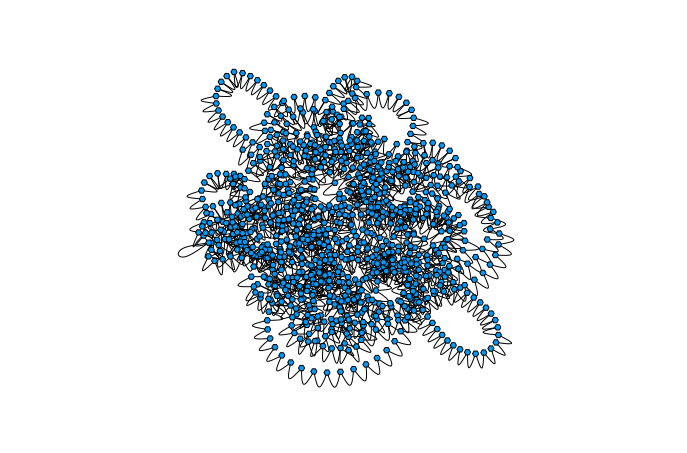

In [16]:
Eisenia.plot_graph(graph)

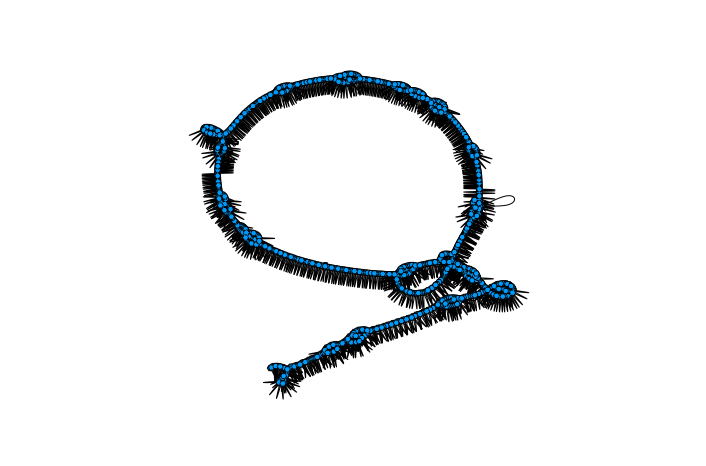

In [17]:
Eisenia.plot_graph(Eisenia.KmerGraph(BioSequences.BigDNAMer{11}, genome_sequences))

In [ ]:
Eisenia.plot_graph(Eisenia.KmerGraph(BioSequences.BigDNAMer{13}, genome_sequences))

In [ ]:
Eisenia.plot_graph(Eisenia.KmerGraph(BioSequences.BigDNAMer{17}, genome_sequences))